The acquired dataset contains households energy consumption information
collected on a daily basis over a period of time. The collected data indicates:
the Day order within the week, the period of measurement, the hour of measurement, the number of electric appliances active, and the measured electricity
consumption.
The day of the week indicates 1 for Monday, 2 for Tuesday, and so on...The
period of the day indicates 1 for 0h to 5.59h, 2 for 6h to 11.59h, 3 for 12h to
17.59h, and 4 from 18h to 23.59h. The hour indicates 1 for the first hour of the
period, 2 for the second, and so on..

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     #optimizer
import time

#Picking a manual seed for randomization
np.random.seed(1234)
torch.manual_seed(123)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))

cpu


###Clustering

In [ ]:
#We first preprocess the data by normalizing it, to ensure features are on the same scale
df = pd.read_csv('Team1.csv')
df.head(3)

,DayOfWeek,Period,NbrAppliances,Hour,KWH
0,4,4,0,1,0.000
1,4,4,0,2,0.002
2,4,4,2,3,0.088


In [ ]:
X = df.drop('KWH', axis=1)  # Selecting the input features
#Next we normalize the input features
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_norm = scalar.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_norm)

#We add a cluster label to the original data
df['Cluster'] = clusters
df.head(3)

,DayOfWeek,Period,NbrAppliances,Hour,KWH,Cluster
0,4,4,0,1,0.000,2
1,4,4,0,2,0.002,2
2,4,4,2,3,0.088,1


In [ ]:
#Analyzing the clusters, by
cluster_analysis = df.groupby('Cluster')['KWH'].mean() #This will print the mean consumption for each cluster
print(cluster_analysis)

Cluster
0    0.197235
1    0.326401
2    0.162743
Name: KWH, dtype: float64


In [ ]:
#We can also check the cluster sizes
print('Number of Samples in each cluster')
cluster_sizes = df['Cluster'].value_counts()
print(cluster_sizes)

Number of Samples in each cluster
Cluster
0    349
1    344
2    315
Name: count, dtype: int64


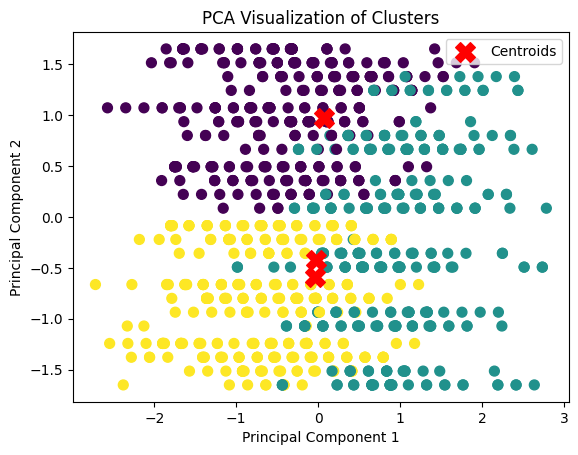

In [ ]:
#Visualizing the clustering. We first reduce the dimension using PCA
from sklearn.decomposition import PCA

# Reduce dimensions to 2 using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(X_norm)

# Plot the reduced features
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



In [ ]:
#Identifying potential outliers, by computing distance to the centroids
distances = kmeans.transform(X_norm)
outlier_scores = distances.min(axis=1)  # Minimum distance to any centroid
threshold = np.percentile(outlier_scores, 95)  # 95th percentile
outliers_kmeans = df[outlier_scores > threshold]
print(f'Number of Outliers: {outliers_kmeans.shape[0]}')
print(outliers_kmeans)

Number of Outliers: 50
     DayOfWeek  Period  NbrAppliances  Hour    KWH  Cluster
0            4       4              0     1  0.000        2
1            4       4              0     2  0.002        2
24           5       4              2     1  0.108        2
29           5       4              2     6  0.101        0
38           6       2              1     3  0.073        2
41           6       2              1     6  0.088        0
44           6       3              1     3  0.117        2
48           6       4              2     1  0.109        2
49           6       4              2     2  0.112        2
51           6       4              2     4  0.105        1
52           6       4              2     5  0.112        0
53           6       4              2     6  0.085        0
57           7       1              2     4  0.090        0
66           7       3              2     1  0.889        2
77           7       4              2     6  0.112        0
97           1   

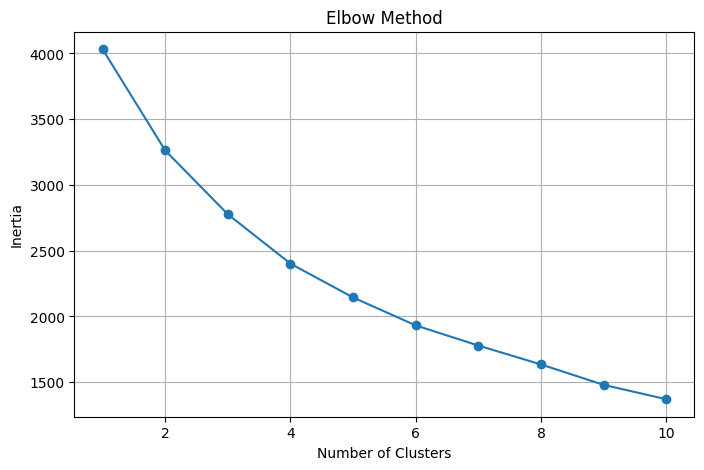

In [ ]:
#Using the Elbow Method to choose the optimal number of clusters
# Initialize an empty list to store inertia values
inertia = []

# Try different numbers of clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_norm)
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

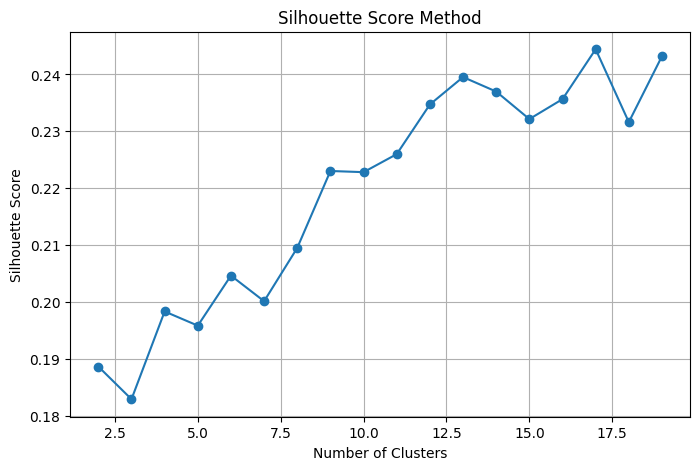

In [ ]:
#Using the Silhouette score to determine the optimal number of clusters
from sklearn.metrics import silhouette_score

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Trying different numbers of clusters
for k in range(2, 20):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_norm)
    score = silhouette_score(X_norm, clusters)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

####Detecting Outliers using DBSCAN

###The Neural Network

In [ ]:
class NN(nn.Module):
  #The input layer has n features
  def __init__(self,layers, activation_fn = nn.ReLU()):
    super(NN,self).__init__() #Instantiate the nn.Module
    self.activation = activation_fn

    #Defining the layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      #nn.init.zeros_(self.linears[i].bias.data

  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

###Data Preprocessing

In [ ]:
df_normal = pd.read_csv('Team1.csv')
df_normal.head(3)

,DayOfWeek,Period,NbrAppliances,Hour,KWH
0,4,4,0,1,0.000
1,4,4,0,2,0.002
2,4,4,2,3,0.088


In [ ]:
df_hybrid = pd.read_csv('Team1_2.csv') #For the hybrid model
df_hybrid.head(3)

,DayOfWeek,Period,NbrAppliances,Hour,KWH-6,KWH-5,KWH-4,KWH-3,KWH-2,KWH-1,KWH
0,5,1,2,1,0.000,0.002,0.088,0.111,0.109,0.075,0.084
1,5,1,2,2,0.002,0.088,0.111,0.109,0.075,0.084,0.101
2,5,1,2,3,0.088,0.111,0.109,0.075,0.084,0.101,0.089


In [ ]:
df_auto = pd.read_csv('Team1_3.csv') #For the auto_regressive model
df_auto.head(3)

,KWH-6,KWH-5,KWH-4,KWH-3,KWH-2,KWH-1,KWH
0,0.000,0.002,0.088,0.111,0.109,0.075,0.084
1,0.002,0.088,0.111,0.109,0.075,0.084,0.101
2,0.088,0.111,0.109,0.075,0.084,0.101,0.089


In [ ]:
#Checking for NaN values
df_normal.isnull().sum()

,0
DayOfWeek,0
Period,0
NbrAppliances,0
Hour,0
KWH,0


In [ ]:
#Checking for NaN values
df_hybrid.isnull().sum()

,0
DayOfWeek,0
Period,0
NbrAppliances,0
Hour,0
KWH-6,0
KWH-5,0
KWH-4,0
KWH-3,0
KWH-2,0
KWH-1,0


In [ ]:
#Checking for NaN values
df_auto.isnull().sum()

,0
KWH-6,0
KWH-5,0
KWH-4,0
KWH-3,0
KWH-2,0
KWH-1,0
KWH,0


In [ ]:
#To check the number of values in each dataset, we can use the shape function
print(f"The number of values and features in the normal dataset is {df_normal.shape}")
print(f"The number of values and features in the hybrid dataset is {df_hybrid.shape}")
print(f"The number of values and features in the auto-regressive dataset is {df_auto.shape}")

The number of values and features in the normal dataset is (1008, 5)
The number of values and features in the hybrid dataset is (1002, 11)
The number of values and features in the auto-regressive dataset is (1002, 7)


In [ ]:
from sklearn.model_selection import train_test_split
#Initializing the features and target. Then, splitting the data

X_hybrid = df_hybrid.drop('KWH', axis=1)  # Input features
y_hybrid = df_hybrid['KWH']  # Target variable


X_normal = df_normal.drop('KWH', axis=1)  # Input features
y_normal = df_normal['KWH']  # Target variable

X_auto = df_auto.drop('KWH', axis=1)  # Input features
y_auto = df_auto['KWH']  # Target variable

# Splitting data into training and testing sets
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
    X_hybrid, y_hybrid, test_size=0.2, random_state=42
)

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=42
)

X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(
    X_auto, y_auto, test_size=0.2, random_state=42
)

print("Training Features for hybrid data:\n", X_train_hybrid.shape)
print("Testing Features for hybrid data:\n", X_test_hybrid.shape)
print("Training Target for hybrid data:\n", y_train_hybrid.shape)
print("Testing Target for hybrid data:\n", y_test_hybrid.shape)
print("####################################################")

print("Training Features for normal data:\n", X_train_normal.shape)
print("Testing Features for normal data:\n", X_test_normal.shape)
print("Training Target for normal data:\n", y_train_normal.shape)
print("Testing Target for normal data:\n", y_test_normal.shape)
print("####################################################")

print("Training Features for auto-regressive data:\n", X_train_auto.shape)
print("Testing Features for auto-regressive data:\n", X_test_auto.shape)
print("Training Target for auto-regressive data:\n", y_train_auto.shape)
print("Testing Target for auto-regressive data:\n", y_test_auto.shape)

Training Features for hybrid data:
 (801, 10)
Testing Features for hybrid data:
 (201, 10)
Training Target for hybrid data:
 (801,)
Testing Target for hybrid data:
 (201,)
####################################################
Training Features for normal data:
 (806, 4)
Testing Features for normal data:
 (202, 4)
Training Target for normal data:
 (806,)
Testing Target for normal data:
 (202,)
####################################################
Training Features for auto-regressive data:
 (801, 6)
Testing Features for auto-regressive data:
 (201, 6)
Training Target for auto-regressive data:
 (801,)
Testing Target for auto-regressive data:
 (201,)


In [ ]:
#Converting data into Numpy array
data_names_hybrid = ['X_train_hybrid', 'y_train_hybrid', 'X_test_hybrid', 'y_test_hybrid']
for data in data_names_hybrid:
  globals()[data] = globals()[data].values

data_names_normal = ['X_train_normal', 'y_train_normal', 'X_test_normal', 'y_test_normal']
for data in data_names_normal:
  globals()[data] = globals()[data].values

data_names_auto = ['X_train_auto', 'y_train_auto', 'X_test_auto', 'y_test_auto']
for data in data_names_auto:
  globals()[data] = globals()[data].values

In [ ]:
y_train_hybrid = y_train_hybrid.reshape(-1, 1)
y_test_hybrid = y_test_hybrid.reshape(-1, 1)

print('y_test_hybrid has shape: ', y_test_hybrid.shape)
print('y_train_hybrid has shape:', y_train_hybrid.shape)
print('#########################################')

y_train_normal = y_train_normal.reshape(-1, 1)
y_test_normal = y_test_normal.reshape(-1, 1)

print('y_test_normal has shape: ', y_test_normal.shape)
print('y_train_normal has shape:', y_train_normal.shape)
print('#########################################')

y_train_auto = y_train_auto.reshape(-1, 1)
y_test_auto = y_test_auto.reshape(-1, 1)

print('y_test_auto has shape: ', y_test_auto.shape)
print('y_train_auto has shape:', y_train_auto.shape)
print('#########################################')

y_test_hybrid has shape:  (201, 1)
y_train_hybrid has shape: (801, 1)
#########################################
y_test_normal has shape:  (202, 1)
y_train_normal has shape: (806, 1)
#########################################
y_test_auto has shape:  (201, 1)
y_train_auto has shape: (801, 1)
#########################################


###Training

In [ ]:
#Defining the hyperparameters
layers_hybrid = [10,50,50,1]; lr = 1e-2; epochs = 100
layers_normal = [4,50,50,1]; layers_auto = [6,50,50,1]


#Next we create an instance of the model
model_hybrid = NN(layers_hybrid).to(device); model_normal = NN(layers_normal).to(device); model_auto = NN(layers_auto).to(device)
print(model_hybrid)
print(model_normal)
print(model_auto)
#params = list(model.parameters())
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=lr) #For back-propagation, we use the Adam optimizer
optimizer_auto = optim.Adam(model_auto.parameters(), lr=lr) #We use the Relu activation function
optimizer_normal = optim.Adam(model_normal.parameters(), lr=lr)

NN(
  (activation): ReLU()
  (linears): ModuleList(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)
NN(
  (activation): ReLU()
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)
NN(
  (activation): ReLU()
  (linears): ModuleList(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [ ]:
#We first convert the data into tensor
for data in data_names_hybrid:
  globals()[data] = torch.FloatTensor(globals()[data]).to(device)

for data in data_names_normal:
  globals()[data] = torch.FloatTensor(globals()[data]).to(device)

for data in data_names_auto:
  globals()[data] = torch.FloatTensor(globals()[data]).to(device)

In [ ]:
#First, we train the hybrid model

train_losses_hybrid = []; test_losses_hybrid = []
for epoch in range(1,epochs+1):
  if epoch == 1:
    print("Epoch: Training Loss ------------- Test Loss")
  model_hybrid.train() #This sets the model to training mode

  #The forward pass
  predictions = model_hybrid(X_train_hybrid)
  train_loss = criterion(predictions,y_train_hybrid)
  train_losses_hybrid.append(train_loss.detach().cpu().numpy()) #This stores the losses

  #Back_propagation
  optimizer_hybrid.zero_grad()
  train_loss.backward()
  optimizer_hybrid.step()

  #Computing and printing both losses
  if (epoch) % (epochs/10) == 0:
    model_hybrid.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed during evaluation
      test_predictions = model_hybrid(X_test_hybrid)
      test_loss = criterion(test_predictions, y_test_hybrid)
      test_losses_hybrid.append(test_loss.detach().cpu().numpy())

    # Print losses
    print(f"{epoch} : {train_loss.detach().cpu().numpy():.5f} ------------- {test_loss.detach().cpu().numpy():.5f}")

Epoch: Training Loss ------------- Test Loss
10 : 0.14908 ------------- 0.26342
20 : 0.12121 ------------- 0.09995
30 : 0.07846 ------------- 0.08094
40 : 0.07123 ------------- 0.07681
50 : 0.06862 ------------- 0.07502
60 : 0.06753 ------------- 0.07351
70 : 0.06674 ------------- 0.07140
80 : 0.06568 ------------- 0.07054
90 : 0.06492 ------------- 0.06931
100 : 0.06437 ------------- 0.06813


There is no underfitting and overfitting

In [ ]:
#Next, we train the normal model

train_losses_normal = []; test_losses_normal = []
for epoch in range(1,epochs+1):
  if epoch == 1:
    print("Epoch: Training Loss ------------- Test Loss")
  model_normal.train() #This sets the model to training mode

  #The forward pass
  predictions = model_normal(X_train_normal)
  train_loss = criterion(predictions,y_train_normal)
  train_losses_normal.append(train_loss.detach().cpu().numpy()) #This stores the losses

  #Back_propagation
  optimizer_normal.zero_grad()
  train_loss.backward()
  optimizer_normal.step()

  #Computing and printing both losses
  if (epoch) % (epochs/10) == 0:
    model_normal.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed during evaluation
      test_predictions = model_normal(X_test_normal)
      test_loss = criterion(test_predictions, y_test_normal)
      test_losses_normal.append(test_loss.detach().cpu().numpy())

    # Print losses
    print(f"{epoch} : {train_loss.detach().cpu().numpy():.5f} ------------- {test_loss.detach().cpu().numpy():.5f}")

Epoch: Training Loss ------------- Test Loss
10 : 0.06817 ------------- 0.12656
20 : 0.07248 ------------- 0.10299
30 : 0.07529 ------------- 0.11707
40 : 0.06544 ------------- 0.10606
50 : 0.06510 ------------- 0.10271
60 : 0.06419 ------------- 0.10284
70 : 0.06341 ------------- 0.10331
80 : 0.06287 ------------- 0.10307
90 : 0.06241 ------------- 0.10279
100 : 0.06199 ------------- 0.10308


In [ ]:
#Finally, we train the auto-regressive model

train_losses_auto = []; test_losses_auto = []
for epoch in range(1,epochs+1):
  if epoch == 1:
    print("Epoch: Training Loss ------------- Test Loss")
  model_auto.train() #This sets the model to training mode

  #The forward pass
  predictions = model_auto(X_train_auto)
  train_loss = criterion(predictions,y_train_auto)
  train_losses_auto.append(train_loss.detach().cpu().numpy()) #This stores the losses

  #Back_propagation
  optimizer_auto.zero_grad()
  train_loss.backward()
  optimizer_auto.step()

  #Computing and printing both losses
  if (epoch) % (epochs/10) == 0:
    model_auto.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed during evaluation
      test_predictions = model_auto(X_test_auto)
      test_loss = criterion(test_predictions, y_test_auto)
      test_losses_auto.append(test_loss.detach().cpu().numpy())

    # Print losses
    print(f"{epoch} : {train_loss.detach().cpu().numpy():.5f} ------------- {test_loss.detach().cpu().numpy():.5f}")

Epoch: Training Loss ------------- Test Loss
10 : 0.07434 ------------- 0.08018
20 : 0.06779 ------------- 0.07835
30 : 0.06335 ------------- 0.07288
40 : 0.05948 ------------- 0.06941
50 : 0.05580 ------------- 0.06542
60 : 0.05351 ------------- 0.06260
70 : 0.05172 ------------- 0.06197
80 : 0.05034 ------------- 0.06230
90 : 0.04893 ------------- 0.06308
100 : 0.04764 ------------- 0.06544


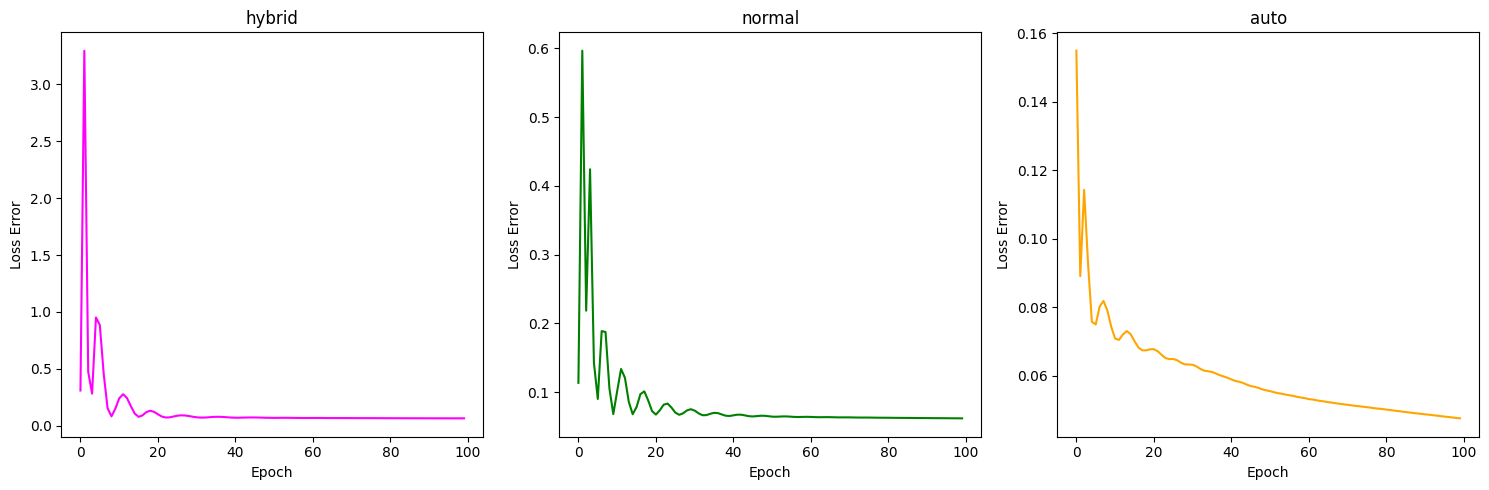

In [ ]:
#Making the train and test losses into a dictionary
train_losses = {'hybrid': train_losses_hybrid, 'normal': train_losses_normal, 'auto': train_losses_auto}
test_losses = {'hybrid': test_losses_hybrid, 'normal': test_losses_normal, 'auto': test_losses_auto}

#Now we plot the train losses
# First, we create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, len(train_losses), figsize=(15, 5))

colors = ['magenta', 'green', 'orange']  # Define a list of colors

#Next we loop through the data and the axes
for ax, (title, losses), color in zip(axes, train_losses.items(), colors):
  ax.plot(range(epochs), losses, color = color)  # Plot the data
  ax.set_title(title)            # Set the title
  ax.set_xlabel('Epoch')         # Set x-axis label
  ax.set_ylabel('Loss Error')    # Set y-axis label

# Adjusting the layout and show the plots
plt.tight_layout()
plt.show()

###Evaluating the model


In [ ]:
test_loss = test_losses_hybrid[-1]
print(f"Test Loss: {test_loss:.5f}")

Test Loss: 0.06813


In [ ]:
with torch.no_grad():
  y_hat_hybrid = model_hybrid(X_test_hybrid)
  y_hat_normal = model_normal(X_test_normal)
  y_hat_auto = model_auto(X_test_auto)

y_hat_dict = {'hybrid': y_hat_hybrid, 'normal': y_hat_normal, 'auto': y_hat_auto}

y_test_dict = {'hybrid': y_test_hybrid, 'normal': y_test_normal, 'auto': y_test_auto}

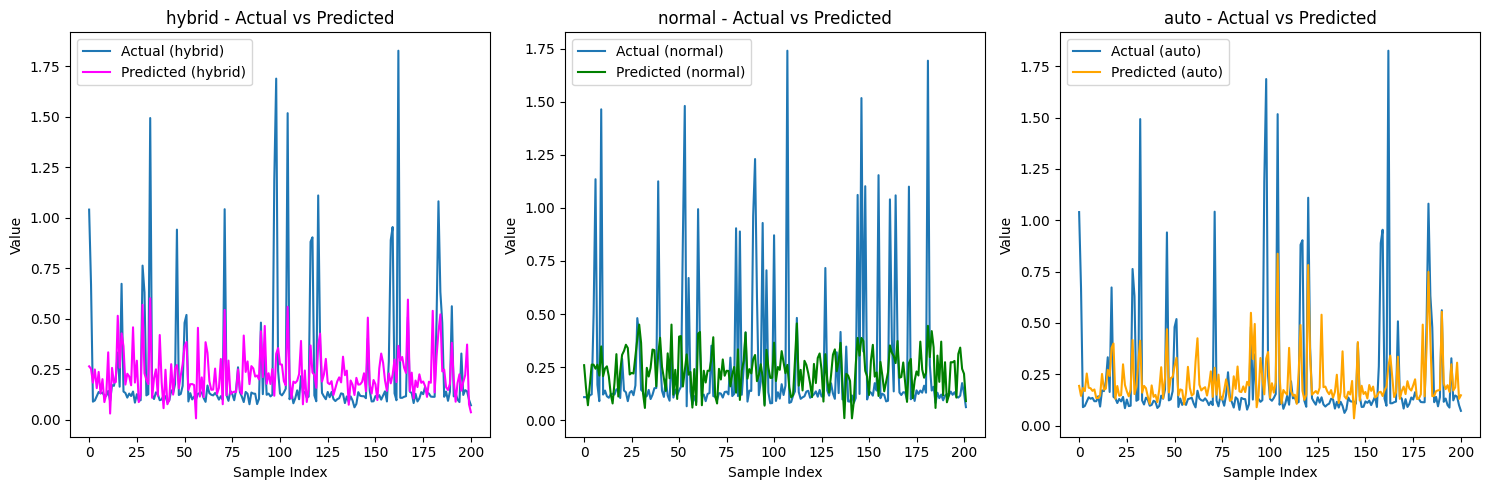

In [ ]:
#Now we plot the predictions
# First, we create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, len(y_test_dict), figsize=(15, 5))
for ax, key, color in zip(axes, y_test_dict, colors):
  # Plot the actual and predicted values for each key
  ax.plot(range(len(y_test_dict[key])), y_test_dict[key], label=f'Actual ({key})')
  ax.plot(range(len(y_hat_dict[key])), y_hat_dict[key], label=f'Predicted ({key})', color = color)

  # Customize the subplot
  ax.set_title(f'{key} - Actual vs Predicted')
  ax.set_xlabel('Sample Index')
  ax.set_ylabel('Value')
  ax.legend()  # Display the legend

# Adjust layout and display the plots
plt.tight_layout()  # Adjust the subplots for better spacing
plt.show()  # Show all subplots

#####Comparison of the based on number of layers and neurons

In [ ]:
def nn_train(model,layers,data_x,data_y,test_x,test_y,epochs):
  train_losses = []; test_losses = []
  for epoch in range(1,epochs+1):
    if epoch == 1:
      print("Epoch: Training Loss ------------- Test Loss")
    model.train() #This sets the model to training mode

    #The forward pass
    predictions = model(data_x)
    train_loss = criterion(predictions,data_y)
    train_losses.append(train_loss.detach().cpu().numpy()) #This stores the losses

    #Back_propagation
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    #Computing and printing both losses
    if (epoch) % (epochs/10) == 0:
      model.eval()  # Set model to evaluation mode
      with torch.no_grad():  # No gradients needed during evaluation
        test_predictions = model(test_x)
        test_loss = criterion(test_predictions, test_y)
        test_losses.append(test_loss.detach().cpu().numpy())

      # Print losses
      print(f"{epoch} : {train_loss.detach().cpu().numpy():.5f} ------------- {test_loss.detach().cpu().numpy():.5f}")
  return train_losses, test_losses

In [ ]:
test_comparison = {}; train_comparison= {}; input = 10
num_of_layers = [2, 4, 6, 8,]; no_of_neurons = [10, 20, 30]
for layer_no in num_of_layers:
  test_comparison[layer_no] = {}
  train_comparison[layer_no] = {}
  for neuron_no in no_of_neurons:
    layers = [input] + [neuron_no]*layer_no + [1]
    print(f"layer_no = {layer_no}, neurons = {neuron_no} => layers = {layers}")
    #Initializing the model
    model = NN(layers).to(device)
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(f"Beginning Training for {layer_no} layers and {neuron_no} neurons")
    print("#################################################################################")
    train_losses, test_losses = nn_train(model,layers,X_train_hybrid,y_train_hybrid,X_test_hybrid,y_test_hybrid,epochs)
    print(f"Training ended for {layer_no} layers and {neuron_no} neurons")
    print("#################################################################################")
    test_comparison[layer_no][neuron_no] = test_losses[-1]
    train_comparison[layer_no][neuron_no] = train_losses[-1]

#We create a dataframe from the dictionaries
test_comparison = pd.DataFrame(test_comparison)
train_comparison = pd.DataFrame(train_comparison)



layer_no = 2, neurons = 10 => layers = [10, 10, 10, 1]
Beginning Training for 2 layers and 10 neurons
#################################################################################
Epoch: Training Loss ------------- Test Loss
10 : 0.10174 ------------- 0.09522
20 : 0.08215 ------------- 0.08663
30 : 0.07924 ------------- 0.08536
40 : 0.07750 ------------- 0.08323
50 : 0.07658 ------------- 0.08135
60 : 0.07578 ------------- 0.08026
70 : 0.07520 ------------- 0.07928
80 : 0.07455 ------------- 0.07889
90 : 0.07388 ------------- 0.07828
100 : 0.07314 ------------- 0.07758
Training ended for 2 layers and 10 neurons
#################################################################################
layer_no = 2, neurons = 20 => layers = [10, 20, 20, 1]
Beginning Training for 2 layers and 20 neurons
#################################################################################
Epoch: Training Loss ------------- Test Loss
10 : 0.12200 ------------- 0.10001
20 : 0.08333 ------------- 0.09

In [ ]:
test_comparison

,2,4,6,8
10,0.07758294,0.0779593,0.071152985,0.07888691
20,0.07184961,0.068684556,0.07164621,0.0760822
30,0.07281796,0.06744877,0.071541965,0.07413492


In [ ]:
train_comparison

,2,4,6,8
10,0.07314107,0.049504284,0.062289834,0.06936593
20,0.060959492,0.05848922,0.04594868,0.046058755
30,0.06283557,0.054510582,0.05755708,0.03868141


#####Comparison based on activation functions

We make a comparison based on several activation functions

In [ ]:
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'tanshrink': nn.Tanhshrink(), 'softsign': nn.Softsign(), 'gelu': nn.GELU(),
               'celu': nn.CELU(), 'leakyrelu': nn.LeakyReLU(0.1)}

activation_list = ['relu', 'tanh', 'tanshrink', 'softsign', 'gelu', 'celu', 'leakyrelu']

In [ ]:
layers = [10,20,20,1]; test_activation = {}; train_activation= {}
for act_fn in activation_list:
  model = NN(layers, activation_fn = activations[act_fn]).to(device)
  print(f"The current activation function is: {model.activation.__class__.__name__}")
  criterion = nn.MSELoss()  # Mean Squared Error Loss
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_losses, test_losses = nn_train(model,layers,X_train_hybrid,y_train_hybrid,X_test_hybrid,y_test_hybrid,epochs)
  test_activation[act_fn] = test_losses[-1]
  train_activation[act_fn] = train_losses[-1]

test_activation = pd.DataFrame(test_activation, index = ['test_loss'])
train_activation = pd.DataFrame(train_activation, index = ['train_loss'])

The current activation function is: ReLU
Epoch: Training Loss ------------- Test Loss
10 : 0.08865 ------------- 0.09290
20 : 0.08018 ------------- 0.08122
30 : 0.07584 ------------- 0.08009
40 : 0.07354 ------------- 0.07853
50 : 0.07133 ------------- 0.07732
60 : 0.06954 ------------- 0.07641
70 : 0.06802 ------------- 0.07574
80 : 0.06677 ------------- 0.07499
90 : 0.06582 ------------- 0.07426
100 : 0.06503 ------------- 0.07368
The current activation function is: Tanh
Epoch: Training Loss ------------- Test Loss
10 : 0.09249 ------------- 0.12013
20 : 0.08772 ------------- 0.08583
30 : 0.08451 ------------- 0.08738
40 : 0.07471 ------------- 0.08080
50 : 0.07064 ------------- 0.07631
60 : 0.06835 ------------- 0.07333
70 : 0.06653 ------------- 0.07189
80 : 0.06532 ------------- 0.07136
90 : 0.06446 ------------- 0.07079
100 : 0.06373 ------------- 0.07001
The current activation function is: Tanhshrink
Epoch: Training Loss ------------- Test Loss
10 : 0.13232 ------------- 0.10128

In [ ]:
test_activation

,relu,tanh,tanshrink,softsign,gelu,celu,leakyrelu
test_loss,0.073678,0.07001,0.066871,0.070516,0.068006,0.071748,0.069044


In [ ]:
train_activation

,relu,tanh,tanshrink,softsign,gelu,celu,leakyrelu
train_loss,0.065028,0.063727,0.061572,0.061356,0.059897,0.062044,0.061365


###Forcasting with new data

To forcast with for the nest 100 period, we train the complete data then use the forcasting data as test data.

In [ ]:
df_train = pd.read_csv('Team1.csv')

df_forcast = pd.read_csv('newpred.csv')
df_forcast.head()

,DayOfWeek,Period,NbrAppliances,Hour
0,1,1,2,1
1,2,2,1,2
2,3,3,2,3
3,4,4,2,4
4,5,1,1,5


In [ ]:
print(f"The number of values and features in the forecasting dataset is {df_forcast.shape}")

The number of values and features in the forecasting dataset is (100, 4)


In [ ]:
#We train the complete dataset
X_train = df_train.drop('KWH', axis=1)  # Input features
y_train = df_train['KWH']  # Target variable

#Converting data into Tensor array
X_train = torch.FloatTensor(X_train.values).to(device)
y_train = torch.FloatTensor(y_train.values.reshape(-1,1)).to(device)

X_forcast = torch.FloatTensor(df_forcast.values).to(device)

In [ ]:
#Next we train the neural network and forcast on the new data

#Defining the hyperparameters
layers = [4,50,50,1]


#Next we create an instance of the model
model = NN(layers).to(device)
print(model)

#params = list(model.parameters())
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer= optim.Adam(model.parameters(), lr=lr) #For back-propagation, we use the Adam optimizer


NN(
  (activation): ReLU()
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [ ]:
#First, we train the model with the dataset

train_losses = []
for epoch in range(1,epochs+1):
  if epoch == 1:
    print("Epoch: Training Loss")
  model.train() #This sets the model to training mode

  #The forward pass
  predictions = model(X_train)
  train_loss = criterion(predictions,y_train)
  train_losses.append(train_loss.detach().cpu().numpy()) #This stores the losses

  #Back_propagation
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  #Computing and printing both losses
  if (epoch) % (epochs/10) == 0:
    # Print losses
    print(f"{epoch} : {train_loss.detach().cpu().numpy():.5f} ")

Epoch: Training Loss
10 : 0.09852 
20 : 0.08437 
30 : 0.07412 
40 : 0.07353 
50 : 0.07248 
60 : 0.07178 
70 : 0.07111 
80 : 0.07025 
90 : 0.06942 
100 : 0.06866 


In [ ]:
#Now we forcast
with torch.no_grad():
  KWH_forcast = model(X_forcast)

In [ ]:
KWH_forcast = KWH_forcast.detach().cpu().numpy()
KWH_forcast.shape

(100, 1)

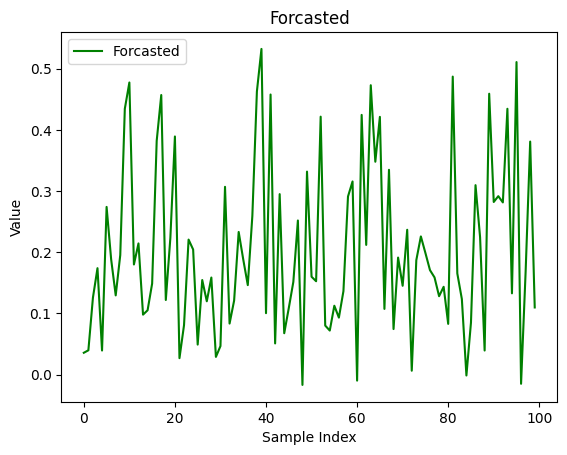

In [ ]:
#Now we plot the predictions
fig, axes = plt.subplots()
axes.plot(range(len(KWH_forcast)), KWH_forcast, label=f'Forcasted', color = 'green')
axes.set_title(f'Forcasted')
axes.set_xlabel('Sample Index')
axes.set_ylabel('Value')
axes.legend()  # Display the legend

plt.show()  # Show all subplots

In [ ]:
#Finally we add the forcasted values to the dataframe and convert to a csv file
df_forcast['KWH_forcast'] = KWH_forcast
df_forcast.to_csv('forcast.csv', index = False)

In [ ]:
df_forcast

,DayOfWeek,Period,NbrAppliances,Hour,KWH_forcast
0,1,1,2,1,0.035699
1,2,2,1,2,0.039729
2,3,3,2,3,0.125743
3,4,4,2,4,0.173899
4,5,1,1,5,0.039357
...,...,...,...,...,...
95,5,4,5,6,0.510682
96,6,1,1,1,-0.014985
97,7,2,3,2,0.168017
98,1,3,5,3,0.380779
